In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import load_model
import copy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
import pickle
import seaborn as sns
from scipy import stats
from sklearn import set_config  
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json

print('Módulos importados')

Módulos importados


In [2]:
# Cargar los datos
data = pd.read_csv("Dataset/post-operative.data")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mid        89 non-null     object
 1   low        89 non-null     object
 2   excellent  89 non-null     object
 3   mid.1      89 non-null     object
 4   stable     89 non-null     object
 5   stable.1   89 non-null     object
 6   stable.2   89 non-null     object
 7   15         89 non-null     object
 8   A          89 non-null     object
dtypes: object(9)
memory usage: 6.4+ KB


In [4]:
# Eliminar filas con valor '?'
data = data.replace('?', float('NaN'))  # Reemplazar '?' con NaN
data = data.dropna()  # Eliminar filas con NaN


In [5]:
# Mapear las categorías en la columna 'A' a valores numéricos
mapping = {'S': 2, 'I': 24, 'A': 64}
data['A'] = data['A'].map(mapping)

# Convertir las dos últimas columnas a datos numéricos y renombrarlas a 'comfort'
data['15'] = pd.to_numeric(data['15'])
data.rename(columns={'15': 'comfort', 'A': 'decision'}, inplace=True)

# Mostrar el DataFrame después de la preparación de datos
print(data)

     mid   low  excellent mid.1    stable  stable.1    stable.2  comfort  \
0    mid  high  excellent  high    stable    stable      stable       10   
1   high   low  excellent  high    stable    stable  mod-stable       10   
2    mid   low       good  high    stable  unstable  mod-stable       15   
3    mid   mid  excellent  high    stable    stable      stable       10   
4   high   low       good   mid    stable    stable    unstable       15   
..   ...   ...        ...   ...       ...       ...         ...      ...   
84   mid   mid  excellent   mid  unstable    stable      stable       10   
85   mid   mid  excellent   mid  unstable    stable      stable       15   
86   mid   mid       good   mid  unstable    stable      stable       15   
87   mid   mid  excellent   mid  unstable    stable      stable       10   
88   mid   mid       good   mid  unstable    stable      stable       15   

    decision  
0        2.0  
1       64.0  
2        NaN  
3       64.0  
4        2.0

In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 88
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mid        86 non-null     object 
 1   low        86 non-null     object 
 2   excellent  86 non-null     object 
 3   mid.1      86 non-null     object 
 4   stable     86 non-null     object 
 5   stable.1   86 non-null     object 
 6   stable.2   86 non-null     object 
 7   comfort    86 non-null     int64  
 8   decision   85 non-null     float64
dtypes: float64(1), int64(1), object(7)
memory usage: 6.7+ KB


In [7]:
data = data.dropna()  # Eliminar filas con NaN

In [8]:
# Lidiar con valores faltantes en columnas categóricas (por ejemplo, reemplazar con la categoría más frecuente)
data['mid'].fillna(data['mid'].mode()[0], inplace=True)
data['low'].fillna(data['low'].mode()[0], inplace=True)
data['excellent'].fillna(data['excellent'].mode()[0], inplace=True)
data['mid.1'].fillna(data['mid.1'].mode()[0], inplace=True)
data['stable'].fillna(data['stable'].mode()[0], inplace=True)
data['stable.1'].fillna(data['stable.1'].mode()[0], inplace=True)
data['stable.2'].fillna(data['stable.2'].mode()[0], inplace=True)


In [9]:
data

,mid,low,excellent,mid.1,stable,stable.1,stable.2,comfort,decision
0,mid,high,excellent,high,stable,stable,stable,10,2.0
1,high,low,excellent,high,stable,stable,mod-stable,10,64.0
3,mid,mid,excellent,high,stable,stable,stable,10,64.0
4,high,low,good,mid,stable,stable,unstable,15,2.0
5,mid,low,excellent,high,stable,stable,mod-stable,5,2.0
...,...,...,...,...,...,...,...,...,...
84,mid,mid,excellent,mid,unstable,stable,stable,10,64.0
85,mid,mid,excellent,mid,unstable,stable,stable,15,2.0
86,mid,mid,good,mid,unstable,stable,stable,15,64.0
87,mid,mid,excellent,mid,unstable,stable,stable,10,64.0


In [10]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def guardarModelo(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("********** Pickle guardado")
        
#Funciones para guardar y cargar la Red Neuronal (Arquitectura y Pesos)
def guardarRNN(model,nombreArchivo):
    print("Guardando Red Neuronal en Archivo")  
    model.save(nombreArchivo+'.h5')
    print("Red Neuronal Grabada en Archivo")   
    
def cargarRNN(nombreArchivo):
    model = load_model(nombreArchivo+'.h5')    
    print("Red Neuronal Cargada desde Archivo") 
    return model

def transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features):
    dataframeTransformado=copy.deepcopy(dataframe)
    cantidadTotalVariables = len(dataframeTransformado.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadVariablesBinarias=cantidadVariablesBinarias+dataframeTransformado[variable].nunique()
    print('Cantidad de variables binarias: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    print('Cantidad de variables que habrá después de transformación de variables: ',cantidadTotalVariablesConTransformacion)
    #Definición de transformadores (preprocesadores)
    #1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
    categorical_ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())])
    categorical_nominal_transformer_ConNombres = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida
    preprocesorCategoricoNumericoConNombres = ColumnTransformer(
        transformers=[
            ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
            ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
        ],remainder='passthrough',n_jobs=-1)
    #2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
    minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler(feature_range=(0, 1)))])
    preprocesorMinMax = ColumnTransformer(transformers =[
        ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
    standardscaler_transformer = Pipeline(steps=[
        ('scaler', StandardScaler(with_mean=True,with_std=True))])
    preprocesorStandardScaler = ColumnTransformer(transformers =[
        ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #Construcción de Pipeline con transformadores
    pipe = Pipeline(steps=[
        ('prepcn', preprocesorCategoricoNumericoConNombres) 
        #('prepstandard', preprocesorStandardScaler)
        #('prepminmax', preprocesorMinMax)
    ])
    #Transformación de variables
    X_Transformado = pipe.fit_transform(dataframeTransformado)
    print('********** Pipeline aplicado')
    guardarPipeline(pipe,'pipePreprocesadores')
    set_config(display='diagram')
    #Formación de dataframe transformado
    cnamesDataset1=[]
    if len(categorical_ordinal_features)!=0:
        cnamesDataset1.extend(categorical_ordinal_features)
    if len(categorical_nominal_features)!=0:
        cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
        cnamesDataset1.extend(cnamesDataset2)
    cnamesDataset3 = numeric_features
    cnamesDataset1.extend(cnamesDataset3)
    print(cnamesDataset1)
    dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
    #dataframeTransformado = pd.concat([dataframeTransformado, salida], axis = 1)
    return dataframeTransformado, pipe

In [11]:
#Selección de variables y separamos Y
dataframe=copy.deepcopy(data)

#Se separa variable independiente:
Y = dataframe.comfort.values
dataframe=dataframe.drop(['comfort'], axis=1)

In [12]:
dataframePreprocesado=copy.deepcopy(dataframe)
categorical_ordinal_features = []
categorical_nominal_features = ['mid','low','excellent','mid.1','stable','stable.1','stable.2'] 
numeric_features = ['decision']
salida = Y

In [13]:
dataframeTransformado, pipe=transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features)
dataframeTransformado.to_csv("Dataset.csv", sep=";",index = False)
guardarPipeline(pipe,'PipeGenerate')
dataframeTransformado.head()

Cantidad de variables antes de transformación de variables:  8
Cantidad de variables binarias:  19
Cantidad de variables que habrá después de transformación de variables:  20
********** Pipeline aplicado
['mid_high', 'mid_low', 'mid_mid', 'low_high', 'low_low', 'low_mid', 'excellent_excellent', 'excellent_good', 'mid.1_high', 'mid.1_low', 'mid.1_mid', 'stable_stable', 'stable_unstable', 'stable.1_mod-stable', 'stable.1_stable', 'stable.1_unstable', 'stable.2_mod-stable', 'stable.2_stable', 'stable.2_unstable', 'decision']


,mid_high,mid_low,mid_mid,low_high,low_low,low_mid,excellent_excellent,excellent_good,mid.1_high,mid.1_low,mid.1_mid,stable_stable,stable_unstable,stable.1_mod-stable,stable.1_stable,stable.1_unstable,stable.2_mod-stable,stable.2_stable,stable.2_unstable,decision
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,64.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,64.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0


In [14]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(dataframeTransformado, Y, test_size=0.2, random_state=42)
X_train.shape[1]

20

<Axes: ylabel='count'>

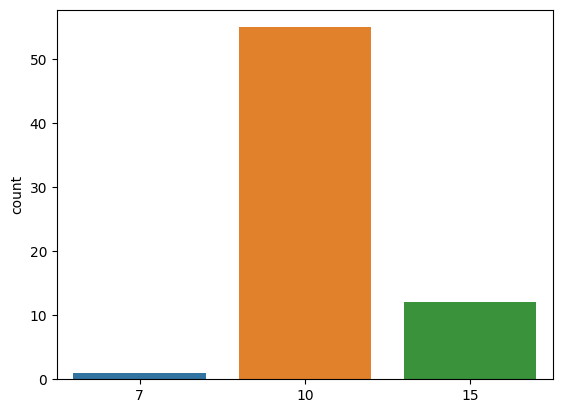

In [15]:
sns.countplot(x=y_train)

In [16]:
# Normalizar los valores de y_train y y_test
max_value = 15  # El valor máximo en y_train es 15
y_train_normalized = y_train / max_value
y_test_normalized = y_test / max_value

In [17]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Normalizar los datos de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Construir la arquitectura de la red neuronal con regularización L2
model = tf.keras.models.Sequential([
    Dense(256, activation='relu', input_shape=(20,), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

# Entrenar el modelo con regularización L2
model.fit(X_train, y_train_normalized, epochs=50, batch_size=1)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test_normalized)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Guardar el modelo en formato Keras nativo
model.save('modelo_red_neuronal.keras')

Epoch 1/50
68/68 [==============================] - 2s 3ms/step - loss: 2.2276 - acc: 0.1618
Epoch 2/50
68/68 [==============================] - 0s 3ms/step - loss: 1.0259 - acc: 0.1765
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6959 - acc: 0.1765
Epoch 4/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6365 - acc: 0.1765
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6191 - acc: 0.1765
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6118 - acc: 0.1765
Epoch 7/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6058 - acc: 0.1765
Epoch 8/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6048 - acc: 0.1765
Epoch 9/50
68/68 [==============================] - 0s 3ms/step - loss: 0.6018 - acc: 0.1765
Epoch 10/50
68/68 [==============================] - 0s 3ms/step - loss: 0.5994 - acc: 0.1765
Epoch 11/50
68/68 [==============================] - 0s 3ms/step - lo

In [18]:
from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import*
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 

#Predicciones
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase) 

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)



1/1 [==============================] - 0s 154ms/step
Mean Absolute Error (MAE): 10.1757
Mean Squared Error (MSE): 113.0607
Root Mean Squared Error (RMSE): 10.633
Accuracy: 1.0
Precision:  1.0
Recall:  1.0
F1: 1.0
